In this notebook, I will compare several binary classification models using a simulated dataset.

The data is simulated using scikit-learn's ```make_classification```. First, the models will be trained and tested on a simple dataset with 2 relevant features. Later, they will be trained and tested on a more complex dataset with both redundant and repeated features without any feature engineering. ```make_classification``` documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

I will try the following scikit-learn classifiers (click on the model name for documentation): [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html),
[LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html),
[KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html),
[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

I will also add multiplayer perceptrons in Keras and PyTorch and evaluate their performances.

Let's create a dataframe to store accuracies of the classifier for comparison later.

In [1]:
import pandas as pd

accuracy_df = pd.DataFrame(columns = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4'])

In [2]:
# create simulated data with 2 features
from sklearn.datasets import make_classification

X, Y = make_classification(n_samples = 1000,
                           n_features = 2,
                           n_informative = 2,
                           n_redundant = 0,
                           n_clusters_per_class = 1,
                           random_state = 47)

In [3]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 47)

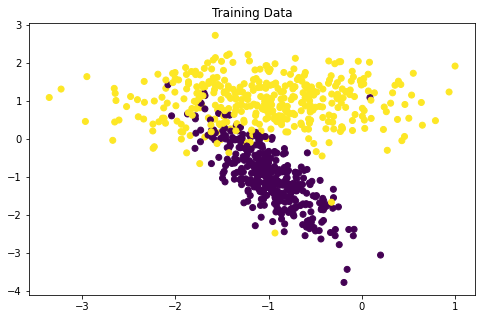

In [4]:
# plot the training data
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(X_train[:,0], X_train[:,1], c = Y_train)
plt.title('Training Data')
plt.show()

In [5]:
# import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [6]:
# initialize scikit-learn classifiers with mostly default values
log_reg = LogisticRegression()
dt_clf = DecisionTreeClassifier()
# initialize Linear SVC with max_iter = 10000 to ensure convergence
linear_svc = LinearSVC(max_iter = 10000)
kn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier()
gb_clf = GradientBoostingClassifier()


clf_list = [log_reg, dt_clf, linear_svc, kn_clf, rf_clf, gb_clf]

clf_names = ['Logistic Regression', 'Decision Tree Classifier', 'Linear SVC',
            'KNN Classifier', 'Random Forest Classifier', 'Gradient Boosting Classfier']

In [7]:
# define a function that will take in training and testing data,
# and then will fit the classifiers and score their predictions

def scikit_clf_fit_score(x_train, y_train, x_test, y_test, dataset_num):
    
    # loop over each classifier in clf_list, fit, score, add score to accuracy_df
    dataset = f'Dataset {dataset_num}'
    
    for i in range(6):
        clf_list[i].fit(x_train, y_train)
        score = clf_list[i].score(x_test, y_test)
        accuracy_df.loc[clf_names[i], dataset] = score
        print(f'{clf_names[i]}: {score}')

In [8]:
%%time
scikit_clf_fit_score(X_train, Y_train, X_test, Y_test, 1)

Logistic Regression: 0.928
Decision Tree Classifier: 0.944
Linear SVC: 0.928
KNN Classifier: 0.952
Random Forest Classifier: 0.944
Gradient Boosting Classfier: 0.952
Wall time: 569 ms


In [9]:
# create a function that fits and evaluates a binary classification model in Keras
from keras.models import Sequential
from keras.layers import Dense

def keras_nn_fit_score(x_train, y_train, x_test, y_test, dataset_num, n_epochs = 50):
    
    dataset = f'Dataset {dataset_num}'
    
    # three layer model with ReLU applied to the first two layers
    # and sigmoid to the last one
    model = Sequential([
    Dense(30, input_shape=(x_train.shape[1],), activation = 'relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')])
    
    # compile the model using binary crossentropy as the loss function and
    # binary accuracy as the evaluation metric
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
    model.fit(x_train, y_train, epochs = n_epochs)
    
    # evaluate using the test data
    results = model.evaluate(x_test, y_test)
    accuracy_df.loc['Keras NN', dataset] = float(f'{results[1]:.3}')
    print(results)

In [10]:
%%time
keras_nn_fit_score(X_train, Y_train, X_test, Y_test, 1)

Epoch 1/50
24/24 [==============================] - 0s 890us/step - loss: 0.6604 - binary_accuracy: 0.6587
Epoch 2/50
24/24 [==============================] - 0s 1ms/step - loss: 0.5153 - binary_accuracy: 0.8933
Epoch 3/50
24/24 [==============================] - 0s 1ms/step - loss: 0.3922 - binary_accuracy: 0.9040
Epoch 4/50
24/24 [==============================] - 0s 1ms/step - loss: 0.3019 - binary_accuracy: 0.9093
Epoch 5/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2511 - binary_accuracy: 0.9240
Epoch 6/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2263 - binary_accuracy: 0.9147
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2159 - binary_accuracy: 0.9267
Epoch 8/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2106 - binary_accuracy: 0.9227
Epoch 9/50
24/24 [==============================] - 0s 1ms/step - loss: 0.2069 - binary_accuracy: 0.9280
Epoch 10/50
24/24 [==============================] - 

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# BCELoss will be used for all neural networks
criterion = nn.BCELoss()

In [12]:
# create a binary classification model in PyTorch
# the NN will be the same except for the number of input nodes for all datasets

class TorchBinaryClassifier(nn.Module):
    
    def __init__(self, in_dimension):
        
        super(TorchBinaryClassifier, self).__init__()
        
        # 3 layer NN similar to the one done in Keras
        self.fc1 = nn.Linear(in_dimension, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 1)
        
        # sigmoid layer for classification
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        # apply ReLU after each of the first two layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # apply sigmoid function before returning the value
        x = self.sig(x)
        
        return x

In [13]:
# speficy train and test data
from torch.utils.data import TensorDataset, DataLoader

# set up a function to get dataloaders
def pytorch_loaders(x_train, y_train, x_test, y_test):
    
    X_train_tensor = torch.from_numpy(x_train).float()
    Y_train_tensor = torch.from_numpy(y_train).float().squeeze()

    X_test_tensor = torch.from_numpy(x_test).float()
    Y_test_tensor = torch.from_numpy(y_test).float()

    trainset = TensorDataset(X_train_tensor, Y_train_tensor)
    testset = TensorDataset(X_test_tensor, Y_test_tensor)

    train_loader = DataLoader(trainset)
    test_loader = DataLoader(testset)
    
    return train_loader, test_loader

In [14]:
# set up a training function
def pytorch_train(model, train_loader, n_epochs = 50):
    
    # define the optimizer
    optimizer = optim.Adam(model.parameters())
    
    # set model to train mode
    model.train()
    print('PyTorch model training...')
    
    for epoch in range(n_epochs):
        # zero the running loss for the epoch
        running_loss = 0.0
        
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.view(-1,1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        print(f'Epoch: {epoch + 1}, training loss: {running_loss/len(train_loader.dataset)}')

In [15]:
import numpy as np

# set up a testing function
def pytorch_test(model, test_loader):
    # set model in evaluation mode
    model.eval()
    print('PyTorch model testing...')
    
    test_loss = 0.0
    correct_predictions = 0
    
    for data, target in test_loader:
        output = model(data)
        loss = criterion(output, target.view(-1,1))
        test_loss += loss.item()
        predicted = np.round(output.detach().numpy().squeeze())
        actual = target.numpy().squeeze()
        
        if predicted == actual:
            correct_predictions += 1
            
    accuracy = correct_predictions/len(test_loader.dataset)
    avg_loss = test_loss/len(test_loader.dataset)
        
    print(f'Loss: {avg_loss}')
    print(f'Accuracy: {accuracy}')
        
    return accuracy

In [16]:
# define a function that will take in the training and testing data
# and combine the previously defined functions to train and test a pytorch nn

def pytorch_nn_fit_score(x_train, y_train, x_test, y_test, dataset_num, n_epochs = 50):
    
    dataset = f'Dataset {dataset_num}'
    
    # initialize a neural network
    net = TorchBinaryClassifier(x_train.shape[1])
    
    # get data loaders from the training and testing data
    train_loader, test_loader = pytorch_loaders(x_train, y_train, x_test, y_test)
    
    # train the network
    pytorch_train(net, train_loader)
    
    # add a blank line for a clearer print-out
    print('\n')
    # test the network
    accuracy = pytorch_test(net, test_loader)
    accuracy_df.loc['PyTorch NN', dataset] = accuracy

In [17]:
%%time
pytorch_nn_fit_score(X_train, Y_train, X_test, Y_test, 1)

PyTorch model training...
Epoch: 1, training loss: 0.2784093919802302
Epoch: 2, training loss: 0.2010430831356983
Epoch: 3, training loss: 0.19297463188709418
Epoch: 4, training loss: 0.18506046479362218
Epoch: 5, training loss: 0.17967862892365277
Epoch: 6, training loss: 0.17535681168948455
Epoch: 7, training loss: 0.1714352330567684
Epoch: 8, training loss: 0.1693501693665118
Epoch: 9, training loss: 0.16674544420505602
Epoch: 10, training loss: 0.16453941584840748
Epoch: 11, training loss: 0.16257151545823822
Epoch: 12, training loss: 0.16133491645105097
Epoch: 13, training loss: 0.15977777679416372
Epoch: 14, training loss: 0.15803487823294077
Epoch: 15, training loss: 0.1567970334664351
Epoch: 16, training loss: 0.15555856731783327
Epoch: 17, training loss: 0.15452891250497972
Epoch: 18, training loss: 0.1531563832855415
Epoch: 19, training loss: 0.15196576762436112
Epoch: 20, training loss: 0.15102056344643158
Epoch: 21, training loss: 0.1503066481180043
Epoch: 22, training loss

Let's look at ```accuracy_df```.

In [18]:
accuracy_df

,Dataset 1,Dataset 2,Dataset 3,Dataset 4
Logistic Regression,0.928,NaN,NaN,NaN
Decision Tree Classifier,0.944,NaN,NaN,NaN
Linear SVC,0.928,NaN,NaN,NaN
KNN Classifier,0.952,NaN,NaN,NaN
Random Forest Classifier,0.944,NaN,NaN,NaN
Gradient Boosting Classfier,0.952,NaN,NaN,NaN
Keras NN,0.948,NaN,NaN,NaN
PyTorch NN,0.948,NaN,NaN,NaN


All models achieved above 90% accuracy. The PyTorch MLP required by far the most lines of code and was the slowest.

Now I will test the same models on a dataset with 4 features, 3 of which are informative, and one is a random linear combination of the others.

In [19]:
X_2, Y_2 = make_classification(n_samples = 1000,
                           n_features = 4,
                           n_informative = 3,
                           n_redundant = 1,
                           n_clusters_per_class = 1,
                           random_state = 47)

X_2_train, X_2_test, Y_2_train, Y_2_test = train_test_split(X_2, Y_2, 
                                                            test_size = 0.25,
                                                            random_state = 47)

<IPython.core.display.Javascript object>


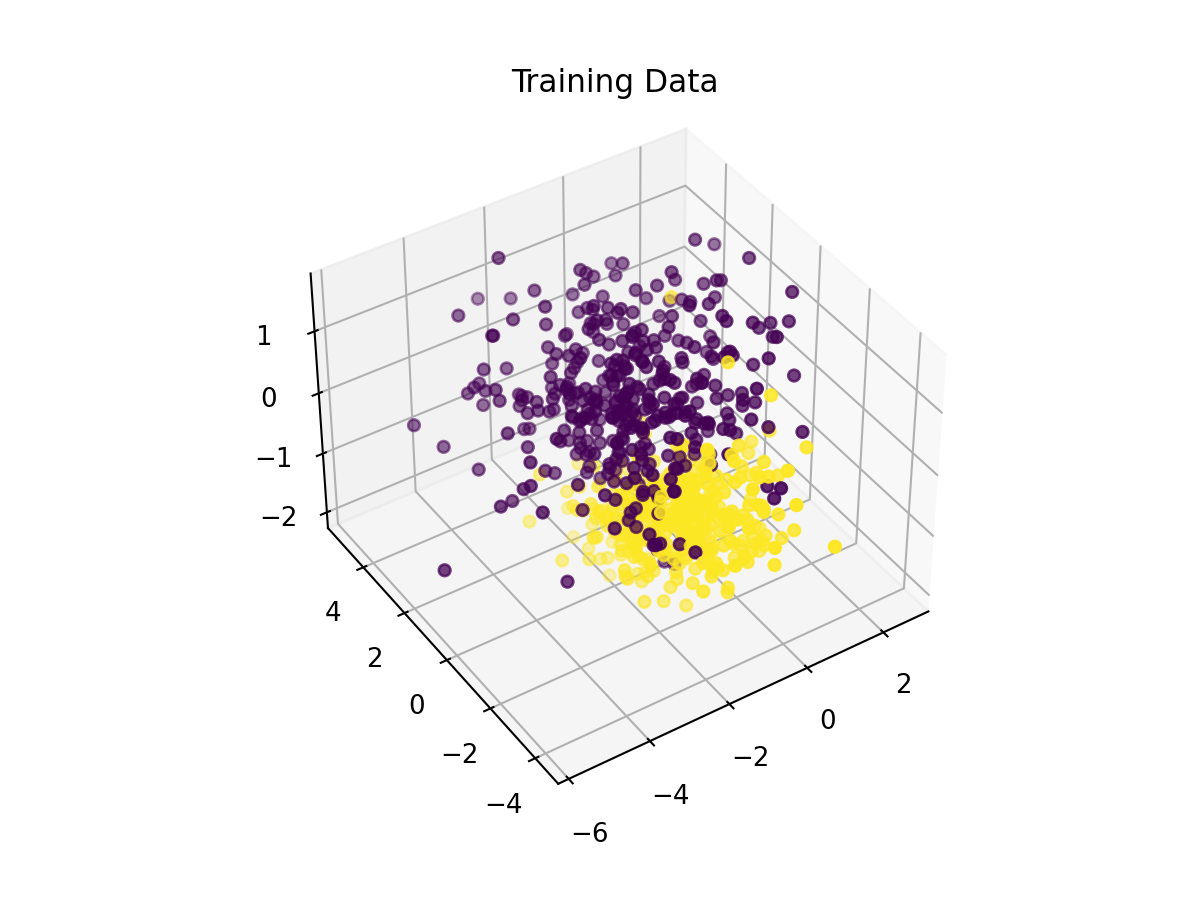

In [20]:
# display the new classes in terms of the first 3 features using an interactive 3d plot
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(X_2_train[:,0], X_2_train[:,1], X_2_train[:,2], c = Y_2_train)
plt.title('Training Data')
plt.show()

In [21]:
%%time
scikit_clf_fit_score(X_2_train, Y_2_train, X_2_test, Y_2_test, 2)

Logistic Regression: 0.928
Decision Tree Classifier: 0.916
Linear SVC: 0.928
KNN Classifier: 0.944
Random Forest Classifier: 0.94
Gradient Boosting Classfier: 0.948
Wall time: 703 ms


In [22]:
%%time
keras_nn_fit_score(X_2_train, Y_2_train, X_2_test, Y_2_test, 2)

Epoch 1/50
24/24 [==============================] - 0s 1ms/step - loss: 0.6535 - binary_accuracy: 0.6453
Epoch 2/50
24/24 [==============================] - 0s 1ms/step - loss: 0.4384 - binary_accuracy: 0.9120
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 0.3245 - binary_accuracy: 0.9120
Epoch 4/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2624 - binary_accuracy: 0.9187
Epoch 5/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2287 - binary_accuracy: 0.9227
Epoch 6/50
24/24 [==============================] - 0s 2ms/step - loss: 0.2097 - binary_accuracy: 0.9240
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1980 - binary_accuracy: 0.9240
Epoch 8/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1916 - binary_accuracy: 0.9280
Epoch 9/50
24/24 [==============================] - 0s 1ms/step - loss: 0.1856 - binary_accuracy: 0.9253
Epoch 10/50
24/24 [==============================] - 0s

In [23]:
%%time
pytorch_nn_fit_score(X_2_train, Y_2_train, X_2_test, Y_2_test, 2)

PyTorch model training...
Epoch: 1, training loss: 0.25330452993449704
Epoch: 2, training loss: 0.19039167641871757
Epoch: 3, training loss: 0.1851490607180419
Epoch: 4, training loss: 0.18076705214840766
Epoch: 5, training loss: 0.17734966842178562
Epoch: 6, training loss: 0.17438816056280773
Epoch: 7, training loss: 0.17203711446964282
Epoch: 8, training loss: 0.16931040804711098
Epoch: 9, training loss: 0.16683832268914986
Epoch: 10, training loss: 0.16444055932644497
Epoch: 11, training loss: 0.16245691620774533
Epoch: 12, training loss: 0.16019180731893295
Epoch: 13, training loss: 0.15856511323408418
Epoch: 14, training loss: 0.15681910292654022
Epoch: 15, training loss: 0.1551742447835715
Epoch: 16, training loss: 0.15390114691490575
Epoch: 17, training loss: 0.1523826380651542
Epoch: 18, training loss: 0.15142191318611098
Epoch: 19, training loss: 0.14978837989460625
Epoch: 20, training loss: 0.14952083225607238
Epoch: 21, training loss: 0.14788173605721447
Epoch: 22, training 

In [24]:
accuracy_df

,Dataset 1,Dataset 2,Dataset 3,Dataset 4
Logistic Regression,0.928,0.928,NaN,NaN
Decision Tree Classifier,0.944,0.916,NaN,NaN
Linear SVC,0.928,0.928,NaN,NaN
KNN Classifier,0.952,0.944,NaN,NaN
Random Forest Classifier,0.944,0.94,NaN,NaN
Gradient Boosting Classfier,0.952,0.948,NaN,NaN
Keras NN,0.948,0.948,NaN,NaN
PyTorch NN,0.948,0.948,NaN,NaN


All models achieved over 90% accuracy again.

For the next dataset, I will use 7 features broken down into 4 informative, 2 redundant (linear combinations of informative features), and 1 repeated (randomly chosen from the previous 6).

In [ ]:
X_3, Y_3 = make_classification(n_samples = 1000,
                           n_features = 7,
                           n_informative = 4,
                           n_redundant = 2,
                           n_repeated = 1,
                           n_clusters_per_class = 1,
                           random_state = 47)

X_3_train, X_3_test, Y_3_train, Y_3_test = train_test_split(X_3, Y_3, 
                                                            test_size = 0.25,
                                                            random_state = 47)

In [ ]:
# fit logistic regression with default parameters
log_reg = LogisticRegression()
log_reg.fit(X_3_train, Y_3_train)
# obtain prediction accuracy on test data 
score = log_reg.score(X_3_test, Y_3_test)
accuracy_df.loc['Logistic Regression', 'Dataset 3'] = score
print(f'Logistirc Regression: {score}')

# fit the decision tree classifier with default parameters
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_3_train, Y_3_train)
# obtain prediction accuracy on test data
score = dt_clf.score(X_3_test, Y_3_test)
accuracy_df.loc['Decision Tree Classifier', 'Dataset 3'] = score
print(f'Decision Tree Classifier: {score}')

# fit linear SVC with max_iter = 10000 to let the solver converge
linear_svc = LinearSVC(max_iter = 10000)
linear_svc.fit(X_3_train, Y_3_train)
# obtain prediction accuracy on test data
score = linear_svc.score(X_3_test, Y_3_test)
accuracy_df.loc['Linear SVC', 'Dataset 3'] = score
print(f'Linear SVC: {score}')

# fit K-neighbors classifier with default parameters
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_3_train, Y_3_train)
# obtain prediction accuracy on the test data
score = kn_clf.score(X_3_test, Y_3_test)
accuracy_df.loc['KNN Classifier', 'Dataset 3'] = score
print(f'KNN Classifier: {score}')

# fit the random forrest classifier with default parameters
rf_clf = RandomForestClassifier()
rf_clf.fit(X_3_train, Y_3_train)
# obtain prediction accuracy on the test data
score = rf_clf.score(X_3_test, Y_3_test)
accuracy_df.loc['Random Forest Classifier', 'Dataset 3'] = score
print(f'Random Forest Classifier: {score}')

# fit the gradient boosting classifier with default parameters
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_3_train, Y_3_train)
# obtain prediction accuracy on the test data
score = gb_clf.score(X_3_test, Y_3_test)
accuracy_df.loc['Gradient Boosting Classifier', 'Dataset 3'] = score
print(f'Gradient Boosting Classifier: {score}')

In [ ]:
%%time
# three layer model with 4 feature input and sigmoid output
model_3 = Sequential([
    Dense(30, input_shape=(7,), activation = 'relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
# compile the model using binary crossentropy as the loss function and
# binary accuracy as the evaluation metric
model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
model_3.fit(X_3_train, Y_3_train, epochs = 50)
# evaluate using the test data
results = model_3.evaluate(X_3_test, Y_3_test)
accuracy_df.loc['Keras NN', 'Dataset 3'] = float(f'{results[1]:.3}')
print(results)

In [ ]:
# create another binary classification model in PyTorch
class TorchBinaryClassifier_3(nn.Module):
    def __init__(self):
        super(TorchBinaryClassifier_3, self).__init__()
        # 3 layer NN similar to the one done in Keras
        self.fc1 = nn.Linear(7, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 1)
        # sigmoid layer for classification
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        # apply ReLU after each of the first two layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # apply sigmoid function before returning the value
        x = self.sig(x)
        
        return x
    
net_3 = TorchBinaryClassifier_3()

In [ ]:
# specify loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net_3.parameters())

In [ ]:
# speficy train and test data
X_3_train_tensor = torch.from_numpy(X_3_train).float()
Y_3_train_tensor = torch.from_numpy(Y_3_train).float().squeeze()

X_3_test_tensor = torch.from_numpy(X_3_test).float()
Y_3_test_tensor = torch.from_numpy(Y_3_test).float()

trainset_3 = TensorDataset(X_3_train_tensor, Y_3_train_tensor)
testset_3 = TensorDataset(X_3_test_tensor, Y_3_test_tensor)

train_loader_3 = DataLoader(trainset_3)
test_loader_3 = DataLoader(testset_3)

In [ ]:
%%time
# train the model
net_3.train()

for epoch in range(50):
    # zero the running loss for the epch
    running_loss = 0.0
    
    for data, target in train_loader_3:
        optimizer.zero_grad()
        output = net_3(data)
        loss = criterion(output, target.view(-1,1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch: {epoch + 1}, training loss: {running_loss/len(train_loader_3.dataset)}')

In [ ]:
# evaluate the model
net_3.eval()

test_loss = 0.0
correct_predictions = 0

for data, target in test_loader_3:
    output = net_3(data)
    loss = criterion(output, target.view(-1,1))
    test_loss += loss.item()
    predicted = np.round(output.detach().numpy().squeeze())
    actual = target.numpy().squeeze()
    if predicted == actual:
        correct_predictions += 1
    
accuracy = correct_predictions/len(test_loader_3.dataset)
accuracy_df.loc['PyTorch NN', 'Dataset 3'] = float(f'{accuracy:.3}')

print(f'Loss: {test_loss/len(test_loader_3.dataset)}')
print(f'Accuracy: {accuracy}')

In [ ]:
accuracy_df

The next dataset will consist of 10 features with the following breakdown: 5 informative, 3 redundant, 2 repeated.

In [ ]:
X_4, Y_4 = make_classification(n_samples = 1000,
                           n_features = 10,
                           n_informative = 5,
                           n_redundant = 3,
                           n_repeated = 2,
                           n_clusters_per_class = 1,
                           random_state = 47)

X_4_train, X_4_test, Y_4_train, Y_4_test = train_test_split(X_4, Y_4, 
                                                            test_size = 0.25,
                                                            random_state = 47)

In [ ]:
# fit logistic regression with default parameters
log_reg = LogisticRegression()
log_reg.fit(X_4_train, Y_4_train)
# obtain prediction accuracy on test data 
score = log_reg.score(X_4_test, Y_4_test)
accuracy_df.loc['Logistic Regression', 'Dataset 4'] = score
print(f'Logistirc Regression: {score}')

# fit the decision tree classifier with default parameters
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_4_train, Y_4_train)
# obtain prediction accuracy on test data
score = dt_clf.score(X_4_test, Y_4_test)
accuracy_df.loc['Decision Tree Classifier', 'Dataset 4'] = score
print(f'Decision Tree Classifier: {score}')

# fit linear SVC with max_iter = 10000 to let the solver converge
linear_svc = LinearSVC(max_iter = 10000)
linear_svc.fit(X_4_train, Y_4_train)
# obtain prediction accuracy on test data
score = linear_svc.score(X_4_test, Y_4_test)
accuracy_df.loc['Linear SVC', 'Dataset 4'] = score
print(f'Linear SVC: {score}')

# fit K-neighbors classifier with default parameters
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_4_train, Y_4_train)
# obtain prediction accuracy on the test data
score = kn_clf.score(X_4_test, Y_4_test)
accuracy_df.loc['KNN Classifier', 'Dataset 4'] = score
print(f'KNN Classifier: {score}')

# fit the random forrest classifier with default parameters
rf_clf = RandomForestClassifier()
rf_clf.fit(X_4_train, Y_4_train)
# obtain prediction accuracy on the test data
score = rf_clf.score(X_4_test, Y_4_test)
accuracy_df.loc['Random Forest Classifier', 'Dataset 4'] = score
print(f'Random Forest Classifier: {score}')

# fit the gradient boosting classifier with default parameters
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_4_train, Y_4_train)
# obtain prediction accuracy on the test data
score = gb_clf.score(X_4_test, Y_4_test)
accuracy_df.loc['Gradient Boosting Classifier', 'Dataset 4'] = score
print(f'Gradient Boosting Classifier: {score}')

In [ ]:
%%time
# three layer model with 4 feature input and sigmoid output
model_4 = Sequential([
    Dense(30, input_shape=(10,), activation = 'relu'),
    Dense(30, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])
# compile the model using binary crossentropy as the loss function and
# binary accuracy as the evaluation metric
model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
model_4.fit(X_4_train, Y_4_train, epochs = 50)
# evaluate using the test data
results = model_4.evaluate(X_4_test, Y_4_test)
accuracy_df.loc['Keras NN', 'Dataset 4'] = float(f'{results[1]:.3}')
print(results)

In [ ]:
# create another binary classification model in PyTorch
class TorchBinaryClassifier_4(nn.Module):
    def __init__(self):
        super(TorchBinaryClassifier_4, self).__init__()
        # 3 layer NN similar to the one done in Keras
        self.fc1 = nn.Linear(10, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 1)
        # sigmoid layer for classification
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        # apply ReLU after each of the first two layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # apply sigmoid function before returning the value
        x = self.sig(x)
        
        return x
    
net_4 = TorchBinaryClassifier_4()

In [ ]:
# specify loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net_4.parameters())

In [ ]:
# speficy train and test data
X_4_train_tensor = torch.from_numpy(X_4_train).float()
Y_4_train_tensor = torch.from_numpy(Y_4_train).float().squeeze()

X_4_test_tensor = torch.from_numpy(X_4_test).float()
Y_4_test_tensor = torch.from_numpy(Y_4_test).float()

trainset_4 = TensorDataset(X_4_train_tensor, Y_4_train_tensor)
testset_4 = TensorDataset(X_4_test_tensor, Y_4_test_tensor)

train_loader_4 = DataLoader(trainset_4)
test_loader_4 = DataLoader(testset_4)

In [ ]:
%%time
# train the model
net_4.train()

for epoch in range(50):
    # zero the running loss for the epch
    running_loss = 0.0
    
    for data, target in train_loader_4:
        optimizer.zero_grad()
        output = net_4(data)
        loss = criterion(output, target.view(-1,1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch: {epoch + 1}, training loss: {running_loss/len(train_loader_4.dataset)}')

In [ ]:
# evaluate the model
net_4.eval()

test_loss = 0.0
correct_predictions = 0

for data, target in test_loader_4:
    output = net_4(data)
    loss = criterion(output, target.view(-1,1))
    test_loss += loss.item()
    predicted = np.round(output.detach().numpy().squeeze())
    actual = target.numpy().squeeze()
    if predicted == actual:
        correct_predictions += 1
    
accuracy = correct_predictions/len(test_loader_4.dataset)
accuracy_df.loc['PyTorch NN', 'Dataset 4'] = float(f'{accuracy:.3}')

print(f'Loss: {test_loss/len(test_loader_4.dataset)}')
print(f'Accuracy: {accuracy}')

In [ ]:
accuracy_df